In [19]:
#--------------------------------------------------------------------
# Import of all neccesary packages
#--------------------------------------------------------------------

import numpy as np
import torch
from matplotlib import pyplot as plt
import scipy as scipy

#----------------------------------------------------------------------------------------------------------------------------------------
# Sample data representing air pressure readings for each drone
# Each row represents a drone, and each column represents a feature (e.g., microphone array readings)
#----------------------------------------------------------------------------------------------------------------------------------------

data_Altura = []
data_ANWB = []
data_ATMOS = []
data_Autel_Evo = []
data_Phantom = []
name_dic = {'Altura.csv': data_Altura, 'ANWB.csv': data_ANWB, 'ATMOS.csv': data_ATMOS, 'Autel_Evo.csv': data_Autel_Evo, 'Phantom.csv': data_Phantom}

def datasets():
    data_lst = ['Altura.csv', 'ANWB.csv', 'ATMOS.csv', 'Autel_Evo.csv', 'Phantom.csv']
    for filename in data_lst:
        data = []
        with open(filename, "r") as file:
            csvreader = csv.reader(file)
            for row in csvreader:
                row1 = []
                for i,e in enumerate(row):
                    row1.append(float(e))
                data.append(row1)
        step = np.array(data[:249999])
        for i,row in enumerate(step.T):
            if i != 0 and i != 16 and  i !=20 and i != 40 and  i !=62 and  i !=63:
                name_dic[filename].append(row)

datasets()

#----------------------------------------------------------------------------------------------------------------------------------------
# Slice the data into a specified number (percentage - sample_percent) of separate datasets
#----------------------------------------------------------------------------------------------------------------------------------------

def data_clean(drone, sample_percent):
    X_data = []
    data_arr = np.array(name_dic[drone]).T
    total_time_points_no = len(data_arr)
    sample_size = int(total_time_points_no * sample_percent)
    for i in range(0,int(1/sample_percent)):
        X = data_arr[sample_size*i:sample_size*(i+1)].T
        X_data  += [X]
    return np.array(X_data)

sample_percent = 0.25
X_data_Altura = data_clean('Altura.csv', sample_percent)
X_data_ANWB = data_clean('ANWB.csv', sample_percent)
X_data_ATMOS = data_clean('ATMOS.csv', sample_percent)
X_data_Autel_Evo = data_clean('Autel_Evo.csv', sample_percent)
X_data_Phantom = data_clean('Phantom.csv', sample_percent)

In [20]:
#--------------------------------------------------------------------
# Finds the blade passing frequency for a given pressure set
#--------------------------------------------------------------------

def GetBPF(Data,Db = 45,NFFT=int(2**15),up = 1000,low = 0,fs=50e3,ctr = 0):
    Data = Data/max(abs(Data))
    pxx,  freq, t, cax = plt.specgram(Data, Fs=fs, NFFT=NFFT)
    plt.close()
    freq = freq[ctr::]
    pxx = pxx[ctr::]
    return freq[np.where(np.isclose(pxx, max(pxx)))[0]]

Epoch 0: loss = 34780.0078125
Epoch 100: loss = 370.71136474609375
Epoch 200: loss = 226.33023071289062
Epoch 300: loss = 38.790199279785156
Epoch 400: loss = 0.18476244807243347
Epoch 500: loss = 0.0054418668150901794
Epoch 600: loss = 0.0010634694481268525
Epoch 700: loss = 0.0002013115445151925
Epoch 800: loss = 3.3073563827201724e-05
Epoch 900: loss = 4.6317240958160255e-06
Root Mean Squared Error: 0.00073635636


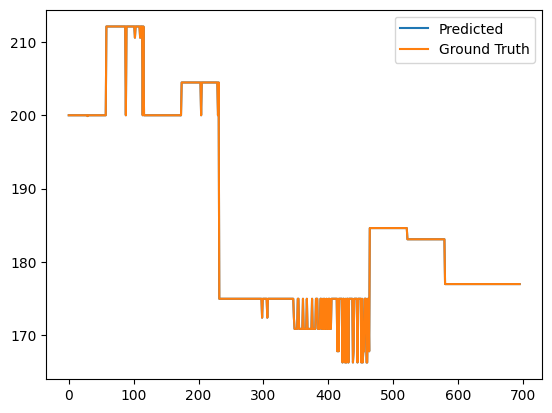

In [21]:
#--------------------------------------------------------------------
# Set the PyTorch and numpy random seeds for reproducibility
#--------------------------------------------------------------------

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

#--------------------------------------------------------------------
# AI model definition
#--------------------------------------------------------------------

def train_regressor_nn(n_features, n_hidden_neurons, learning_rate, n_epochs, X, Y):
    # Define the model:
    model = torch.nn.Sequential(
        torch.nn.Linear(n_features, n_hidden_neurons),
        torch.nn.ReLU(),
        torch.nn.Linear(n_hidden_neurons, n_hidden_neurons),
        torch.nn.ReLU(),
        torch.nn.Linear(n_hidden_neurons, n_hidden_neurons),
        torch.nn.ReLU(),
        torch.nn.Linear(n_hidden_neurons, 1)
    )

    # MSE loss function:
    loss_fn = torch.nn.MSELoss()

    # optimizer:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Learning rate scheduler:
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

    # Train the network:
    for i in range(n_epochs):
        model.train()
        Y_pred = model(X)
        loss = loss_fn(Y_pred, Y)
        if i % 100 == 0:
            print(f'Epoch {i}: loss = {loss.item()}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update learning rate
    
    # return the trained model
    return model
#--------------------------------------------------------------------
# Dataset preparation
#--------------------------------------------------------------------
X,Y = [],[]
for i in X_data_ANWB:
    for e in i:
        X.append(e)
        c = GetBPF(e,)
        if c < 200-20 or c > 200+20:
            Y.append([200])
        else:
            Y.append(GetBPF(e))
for i in X_data_Phantom:
    for e in i:
        X.append(e)
        c = GetBPF(e,ctr = 70)
        if c < 175-20 or c > 175+20   :
            Y.append([175])
        else:
            Y.append(GetBPF(e,ctr = 70))
for i in X_data_Autel_Evo:
    for e in i:
        X.append(e)
        Y.append(GetBPF(e))

X = np.array(X)
Y = np.array(Y)
X = torch.from_numpy(X).float()
Y = torch.from_numpy(Y).float()

#--------------------------------------------------------------------
# Define model parameters
#--------------------------------------------------------------------

n_hidden_neurons = 80
learning_rate = 0.01
n_epochs = 1000
n_features = X.shape[1]

#--------------------------------------------------------------------
# Train the model
#--------------------------------------------------------------------

model = train_regressor_nn(n_features, n_hidden_neurons, learning_rate, n_epochs, X, Y)

#--------------------------------------------------------------------
# Plot the output of the network vs. the ground truth
#--------------------------------------------------------------------

y_pred = model(X).detach().numpy()
Y = Y.numpy()

#--------------------------------------------------------------------
# Print Root Mean Squared Error
#--------------------------------------------------------------------

rmse = np.sqrt(np.mean((y_pred - Y) ** 2))
print('Root Mean Squared Error:', rmse)

#--------------------------------------------------------------------
# Plot results
#--------------------------------------------------------------------

plt.figure()
plt.plot(y_pred, label='Predicted')
plt.plot(Y, label='Ground Truth')
plt.legend()
plt.show()


In [16]:
#--------------------------------------------------------------------
# ATMOS Prediction
#--------------------------------------------------------------------
S = []
for i in X_data_ATMOS:
    for e in i:
        S += [e]
S = np.array(S)
S = torch.from_numpy(S).float()
S_pred = model(S).detach().numpy()
print(np.mean(S_pred))
print(np.median(S_pred))

289.0794
136.7082


In [17]:
#--------------------------------------------------------------------
# Altura Prediction
#--------------------------------------------------------------------
S = []
for i in X_data_Altura:
    for e in i:
        S += [e]
S = np.array(S)
S = torch.from_numpy(S).float()
S_pred = model(S).detach().numpy()
print(np.mean(S_pred))
print(np.median(S_pred))

140.16855
92.10167
